<a href="https://colab.research.google.com/github/aryanranderiya/fastai-deeplearning/blob/main/Lecture1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastai duckduckgo_search icrawler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 13.7 MB/s eta 0:00:00


In [3]:
from fastai.vision.all import *

In [4]:
from icrawler import ImageDownloader
from icrawler.builtin import GoogleImageCrawler
from icrawler.builtin.google import GoogleFeeder, GoogleParser

class MyDownloader(ImageDownloader):
    def get_filename(self, task, default_ext):
        filename = super(MyDownloader, self).get_filename(task, default_ext)
        filename = filename.split(".")[0]
        return self.prefix + filename + ".png"

class MyCrawler(GoogleImageCrawler):
    def __init__(self, feeder_cls=GoogleFeeder, parser_cls=GoogleParser, downloader_cls=MyDownloader, prefix="", *args, **kwargs):
        super().__init__(feeder_cls, parser_cls, downloader_cls, *args, **kwargs)
        self.downloader.prefix = prefix

In [5]:
def search_images(term, max_images=30, folder_name="."):
    print(f"Searching for '{term}'")
    crawler = MyCrawler(
        prefix=term,
        storage={'root_dir': folder_name},
    )
    crawler.crawl(keyword=term, max_num=max_images)

Searching for 'wolf'


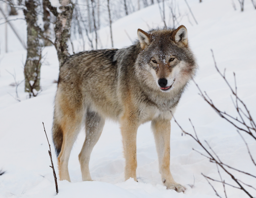

In [6]:
search_images("wolf", 1)
im = Image.open("wolf000001.png")
# icrawler names the downloaded photos from 000001 to 999999
im.to_thumb(256,256)

Searching for 'lion'


ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Lion_waiting_in_Namibia.jpg


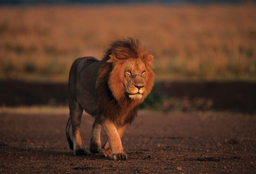

In [7]:
search_images("lion", 1)
im = Image.open("lion000001.png")
im.to_thumb(256,256)

Searching for 'husky'


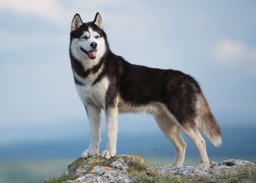

In [8]:
search_images("husky", 1)
im = Image.open("husky000001.png")
im.to_thumb(256,256)

Searching for 'forest'


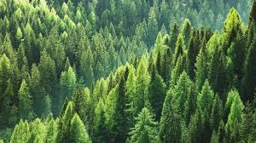

In [9]:
search_images("forest", 2)
im = Image.open("forest000001.png")
im.to_thumb(256,256)

In [12]:
## !! IMPORTANT
# This represents the number of photos that'll be downloaded for each category.
# If you don't want to wait you can lower this number so less images will be downloaded.
# Having less images to train on may lead to worse neural network performance.

no_of_photos = 20 # Default is 20

searches = 'forest',"lion","wolf","husky"
path = Path('classify_images')
from time import sleep

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)

    search_images(f"{search} photo", no_of_photos, dest)
    sleep(10)
    search_images(f"{search} sun photo", no_of_photos, dest)
    sleep(10)
    search_images(f"{search} night photo", no_of_photos, dest)

    print(f"Photos of {search} completed!")

resize_images(path, max_size=400, dest=path, recurse=True)
print(f"Photos resized!")

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest night photo'
Photos of forest completed!
Searching for 'lion photo'
Searching for 'lion sun photo'
Searching for 'lion night photo'
Photos of lion completed!
Searching for 'wolf photo'
Searching for 'wolf sun photo'
Searching for 'wolf night photo'
Photos of wolf completed!
Searching for 'husky photo'
Searching for 'husky sun photo'
Searching for 'husky night photo'
Photos of husky completed!


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (156250000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Photos resized!


In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

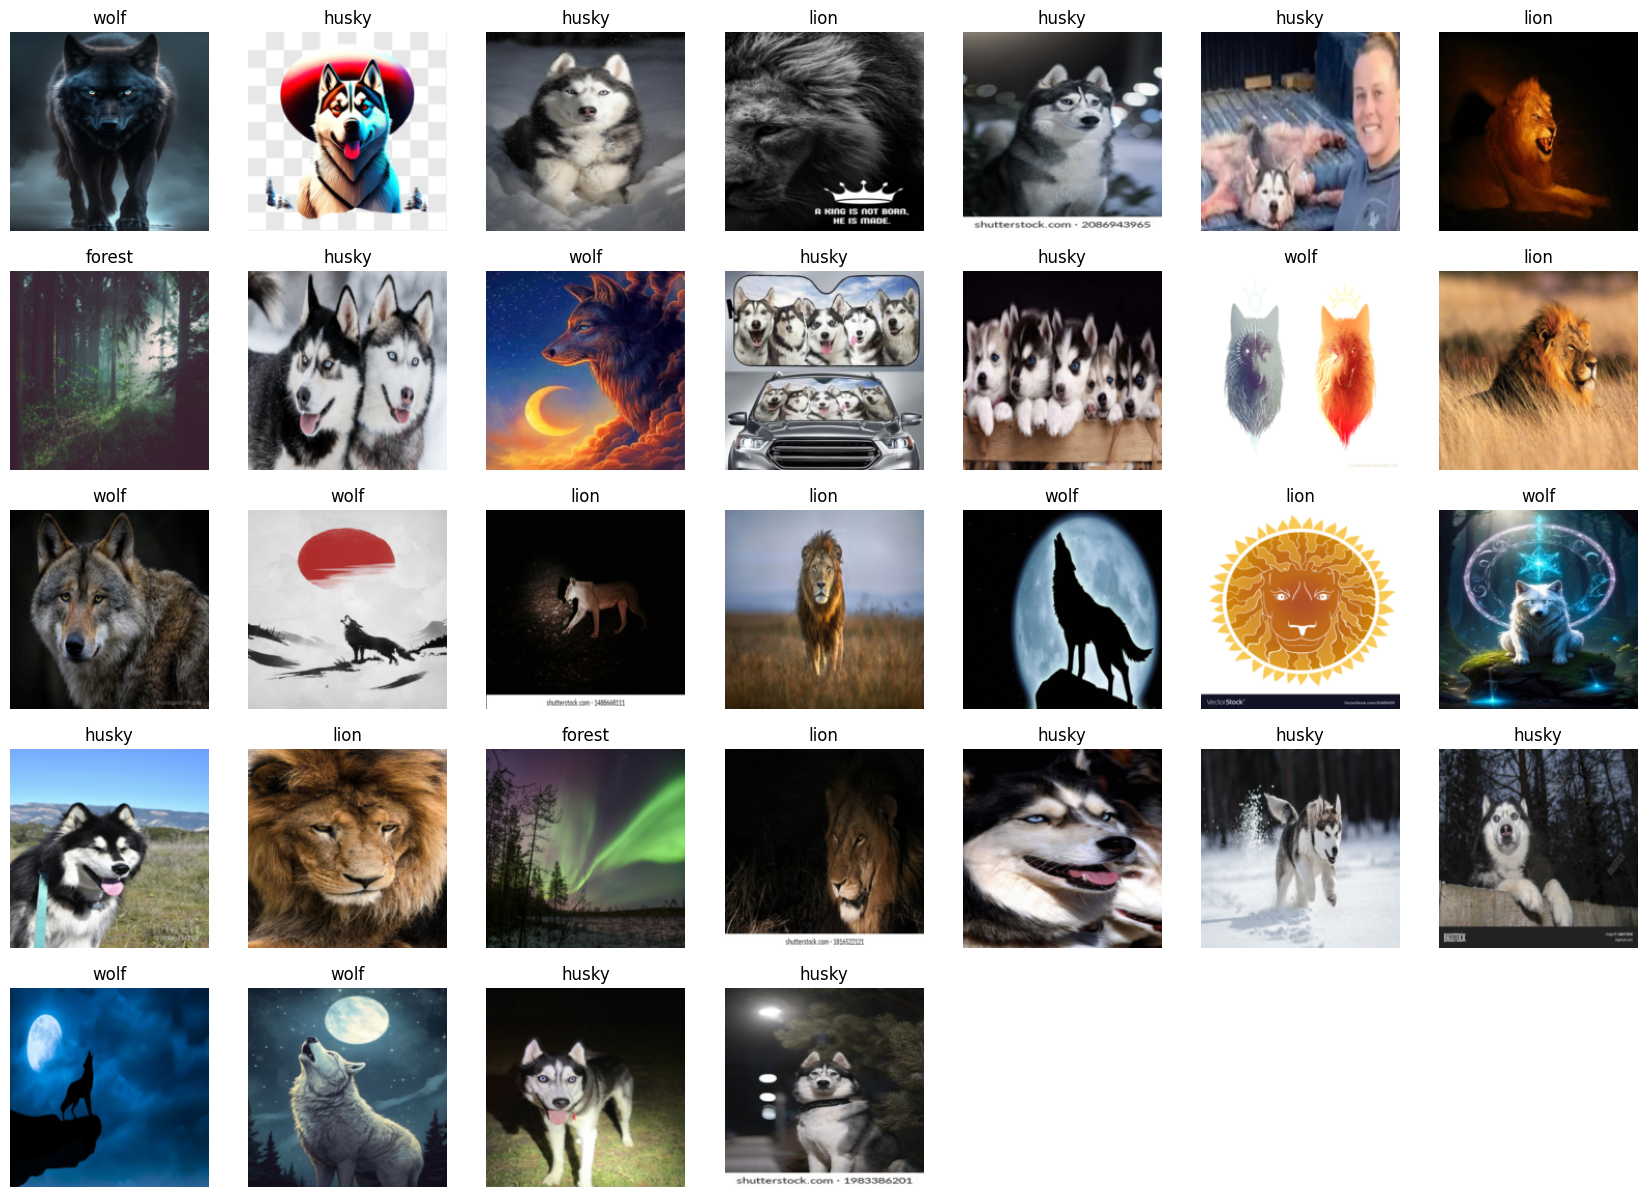

In [14]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=100)

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.759574,0.847041,0.208333,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.504893,0.573530,0.104167,00:02
1,0.354596,0.536972,0.125000,00:02
2,0.240317,0.517365,0.104167,00:01


In [18]:
is_type,is_type_int,probs = learn.predict(PILImage.create('forest000001.png'))
print(f"This is a: {is_type}.")
print(f"Probability it's a {is_type}: {probs[0]:.9f}")

This is a: forest.
Probability it's a forest: 0.998254120
